# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Load pickled data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image data type =",X_train.dtype)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Image data type = uint8
Number of classes = 43


### Include an exploratory visualization of the dataset

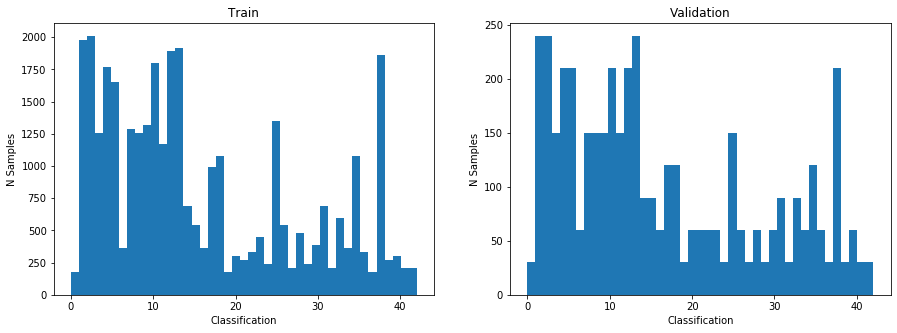

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(y_train,bins=43)
plt.title('Train')
plt.xlabel('Classification')
plt.ylabel('N Samples')
plt.subplot(1,2,2)
plt.hist(y_valid,bins=43)
plt.title('Validation')
plt.xlabel('Classification')
plt.ylabel('N Samples')
plt.show()

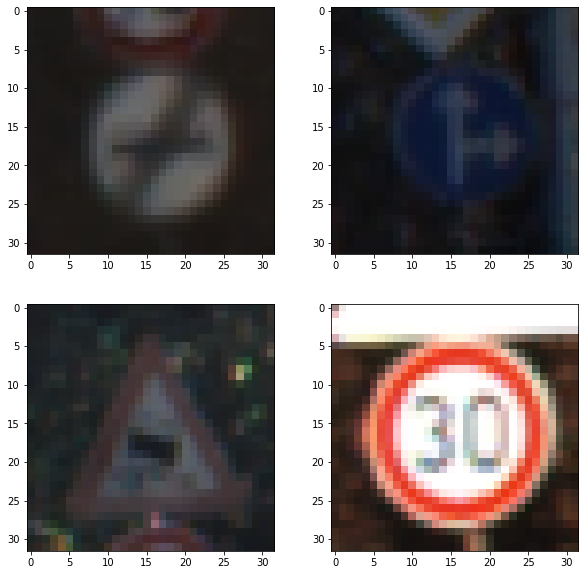

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X_train[0])
plt.subplot(2,2,2)
plt.imshow(X_train[1000])
plt.subplot(2,2,3)
plt.imshow(X_train[2000])
plt.subplot(2,2,4)
plt.imshow(X_train[3000])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The CMSY8 implementation [(Cireşan, Meier, Masci & Schmidhuber, 2011)](https://ieeexplore.ieee.org/abstract/document/6033458) is a solid starting point.

### Pre-process the Data Set

In [7]:
X_train_48 = []
y_train_48 = y_train
for idx,image in enumerate(X_train):
    X_train_48.append(cv2.resize(image,(48,48)))
X_train_48 = np.asarray(X_train_48).reshape(-1,48,48,3)

X_valid_48 = []
y_valid_48 = y_valid
for idx,image in enumerate(X_valid):
    X_valid_48.append(cv2.resize(image,(48,48)))
X_valid_48 = np.asarray(X_valid_48).reshape(-1,48,48,3)

X_test_48 = []
y_test_48 = y_test
for idx,image in enumerate(X_test):
    X_test_48.append(cv2.resize(image,(48,48)))
X_test_48 = np.asarray(X_test_48).reshape(-1,48,48,3)

In [8]:
tf.reset_default_graph()

def global_norm(image):
    mu = tf.reduce_mean(image,axis=(1,2),keep_dims=True)
    std = tf.math.reduce_std(image,axis=(1,2),keepdims=True)
    image = (image-mu)/(std+1e-20)
    return image
    

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
def AHE(image):
    new_image = []
    for chan in range(3):
        new_image.append(clahe.apply(image[:,:,chan]))
    new_image = np.dstack(new_image)
    return new_image

In [9]:
new_images = []
for image in X_train_48:
    new_images.append(np.asarray(AHE(image)))
X_train_48 = np.asarray(new_images)

new_images = []
for image in X_valid_48:
    new_images.append(np.asarray(AHE(image)))
X_valid_48 = np.asarray(new_images)

new_images = []
for image in X_test_48:
    new_images.append(np.asarray(AHE(image)))
X_test_48 = np.asarray(new_images)


X_data = tf.placeholder(tf.float32,shape = (None,48,48,3))
norm = global_norm(X_data)     

X_train_norm = []
X_valid_norm = []
X_test_norm = []
with tf.Session() as sess:
    for offset in range(0,len(X_train_48),1000):
        X_train_norm.append(sess.run(norm,feed_dict={X_data:X_train_48[offset:offset+1000]}))
    for offset in range(0,len(X_valid_48),1000):
        X_valid_norm.append(sess.run(norm,feed_dict={X_data:X_valid_48[offset:offset+1000]}))
    for offset in range(0,len(X_test_48),1000):
        X_test_norm.append(sess.run(norm,feed_dict={X_data:X_test_48[offset:offset+1000]}))
    
X_train_48 = np.concatenate(X_train_norm)
X_valid_48 = np.concatenate(X_valid_norm)
X_test_48 = np.concatenate(X_test_norm)

In [10]:
X_train_48.shape

(34799, 48, 48, 3)

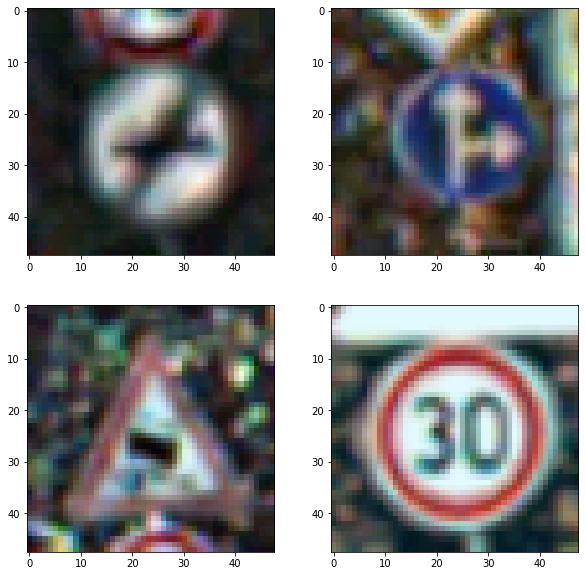

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow((X_train_48[0]-X_train_48[0].min())/(X_train_48[0]-X_train_48[0].min()).max())
plt.subplot(2,2,2)
plt.imshow((X_train_48[1000]-X_train_48[1000].min())/(X_train_48[1000]-X_train_48[1000].min()).max())
plt.subplot(2,2,3)
plt.imshow((X_train_48[2000]-X_train_48[2000].min())/(X_train_48[2000]-X_train_48[2000].min()).max())
plt.subplot(2,2,4)
plt.imshow(((X_train_48[3000]-X_train_48[3000].min())/(X_train_48[3000]-X_train_48[3000].min()).max()))

### Model Architecture

In [12]:
tf.reset_default_graph()

BATCH_SIZE = 50

dropout = tf.placeholder(tf.float32)

In [13]:
def random_transformation(images,t,r):
    images = tf.contrib.image.translate(images,t)    
    images = tf.contrib.image.rotate(images,r,interpolation='BILINEAR')
    return images

t = tf.placeholder(tf.float32,shape=(X_train.shape[0],2))
r = tf.placeholder(tf.float32,shape=(X_train.shape[0]))
images = tf.placeholder(tf.float32,shape=(X_train.shape[0],48,48,3))
new_images = random_transformation(images,t,r)

W0406 21:26:31.417438 139664120964928 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [14]:
from tensorflow.contrib.layers import flatten

def CMSY8(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    
    weights = {"w1": tf.Variable(tf.random.uniform([3,3,3,100],minval=-.05,maxval=.05)),\
               "w2": tf.Variable(tf.random.uniform([4,4,100,150],minval=-.05,maxval=.05)),\
               "w3": tf.Variable(tf.random.uniform([3,3,150,250],minval=-.05,maxval=.05)),\
               "w4": tf.Variable(tf.random.uniform([4000,200],minval=-.05,maxval=.05)),\
               "w5": tf.Variable(tf.random.uniform([200,n_classes],minval=-.05,maxval=.05))\
              }
    biases = {"b1": tf.Variable(tf.zeros(100)),\
              "b2": tf.Variable(tf.zeros(150)),\
              "b3": tf.Variable(tf.zeros(250)),\
              "b4": tf.Variable(tf.zeros(200)),\
              "b5": tf.Variable(tf.zeros(n_classes))
             }
    
    
    # Layer 1
    padding = 'VALID'
    strides = [1,1,1,1]
    layer1 = tf.nn.conv2d(x,weights["w1"],strides=strides,padding=padding)
    layer1 = tf.nn.bias_add(layer1,biases['b1'])

    # Pooling
    strides = [1,2,2,1]
    ksize = [1,2,2,1]
    layer1 = tf.nn.max_pool(layer1,padding=padding,strides=strides,ksize=ksize)
    
    # Normalization
    layer1 = tf.nn.local_response_normalization(layer1)
    
    # Activation.
    layer1 = tf.nn.relu(layer1)
    print(layer1.shape)

    # Layer 2
    padding = 'VALID'
    strides = [1,1,1,1]
    layer2 = tf.nn.conv2d(layer1,weights["w2"],strides=strides,padding=padding)
    layer2 = tf.nn.bias_add(layer2,biases['b2'])

    # Pooling
    strides = [1,2,2,1]
    ksize = [1,2,2,1]
    layer2 = tf.nn.max_pool(layer2,padding=padding,strides=strides,ksize=ksize) 
    
    # Normalization
    layer2 = tf.nn.local_response_normalization(layer2)
    
    # Activation.
    layer2 = tf.nn.relu(layer2)
    print(layer2.shape)
    
    # Layer 3
    padding = 'VALID'
    strides = [1,1,1,1]
    layer3 = tf.nn.conv2d(layer2,weights["w3"],strides=strides,padding=padding)
    layer3 = tf.nn.bias_add(layer3,biases['b3'])

    # Pooling
    strides = [1,2,2,1]
    ksize = [1,2,2,1]
    layer3 = tf.nn.max_pool(layer3,padding=padding,strides=strides,ksize=ksize)
    
    # Normalization
    layer3 = tf.nn.local_response_normalization(layer3)
    
    # Activation.
    layer3 = tf.nn.relu(layer3)
    print(layer3.shape)
    
    # Flatten
    layer3_flat = flatten(layer3)
    
    # Layer 4
    layer4 = tf.add(tf.matmul(layer3_flat,weights['w4']),biases['b4'])
    
    #Activation
    layer4 = tf.nn.relu(layer4)
    
    # Dropout
    layer4 = tf.nn.dropout(layer4, keep_prob=dropout)    
    
    # Layer 5
    logits = tf.add(tf.matmul(layer4,weights['w5']),biases['b5'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
x = tf.placeholder(tf.float32, [None, 48, 48, 3])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [16]:
rate = 0.004

logits = CMSY8(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(rate)
training_operation = optimizer.minimize(loss_operation)

W0406 21:26:37.066442 139664120964928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0406 21:26:37.243437 139664120964928 deprecation.py:506] From <ipython-input-14-8b7c425f07a7>:84: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0406 21:26:37.252137 139664120964928 deprecation.py:323] From <ipython-input-16-4036244cbae0>:4: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on back

(?, 23, 23, 100)
(?, 10, 10, 150)
(?, 4, 4, 250)


In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Data (Skip if not Training)

In [18]:
with tf.Session() as sess:
#     saver.restore(sess,'./CMSY8_v2')
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(10):
        X_train_48, y_train_48 = shuffle(X_train_48, y_train_48)
        X_train_48_tf = sess.run(new_images, feed_dict = {images: X_train_48, 
                                              t: tf.random.uniform(shape=(X_train.shape[0],2),minval=-5,maxval=5).eval(),
                                              r: tf.random.uniform(shape=(X_train.shape[0],),minval=(-10*np.pi/180),maxval=(10*np.pi/180)).eval()})
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_48_tf[offset:end], y_train_48[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout: .6})
        
        train_accuracy = evaluate(X_train_48, y_train_48)
        validation_accuracy = evaluate(X_valid_48, y_valid_48)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './CMSY8_v2')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.951
Validation Accuracy = 0.939

EPOCH 2 ...
Train Accuracy = 0.992
Validation Accuracy = 0.982

EPOCH 3 ...
Train Accuracy = 0.998
Validation Accuracy = 0.986

EPOCH 4 ...
Train Accuracy = 0.999
Validation Accuracy = 0.987

EPOCH 5 ...
Train Accuracy = 0.999
Validation Accuracy = 0.990

EPOCH 6 ...
Train Accuracy = 0.999
Validation Accuracy = 0.986

EPOCH 7 ...
Train Accuracy = 0.998
Validation Accuracy = 0.985

EPOCH 8 ...
Train Accuracy = 0.999
Validation Accuracy = 0.987

EPOCH 9 ...
Train Accuracy = 0.998
Validation Accuracy = 0.989

EPOCH 10 ...
Train Accuracy = 1.000
Validation Accuracy = 0.990

Model saved


#### Load Saved Model

In [19]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,'./CMSY8_v2')
    print('Model Loaded Successfully')
    test_accuracy = evaluate(X_test_48,y_test_48)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

W0406 21:30:45.712589 139664120964928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Model Loaded Successfully
Test Accuracy = 0.984


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [20]:
test_signs_path = 'test_signs/'
test_signs_files = os.listdir(test_signs_path)
test_signs_files = np.sort(test_signs_files)
print(test_signs_files)

test_signs = []
for file in test_signs_files:
    test_signs.append(cv2.cvtColor(cv2.imread(test_signs_path+file),cv2.COLOR_BGR2RGB))
test_labels = [38,1,14,25,13]

['test_image1.jpg' 'test_image2.jpg' 'test_image3.jpg' 'test_image4.jpg'
 'test_image5.jpg']


In [21]:
test_signs = np.asarray(test_signs)
test_labels = np.asarray(test_labels)

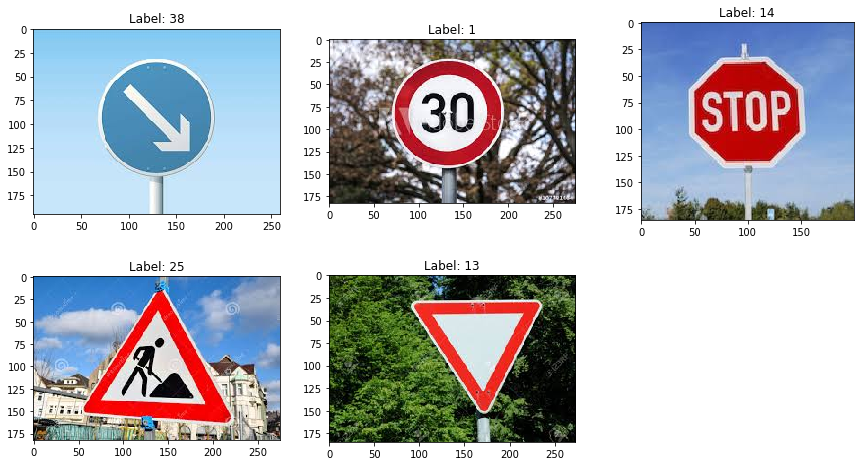

In [22]:
plt.figure(figsize = (15,8))
for idx, image in enumerate(test_signs):
    plt.subplot(2,3,idx+1)
    plt.imshow(image)
    plt.title('Label: '+str(test_labels[idx]))

In [23]:
new_images = []
for i in range(len(test_signs)):
    new_images.append(np.asarray(AHE(test_signs[i])))
test_clahe = np.asarray(new_images)

X_data = tf.placeholder(tf.float32,shape = (None,None,3))
norm = global_norm(X_data)

test_norm = []
with tf.Session() as sess:
    for i in range(len(test_clahe)):
        test_norm.append(sess.run(norm,feed_dict={X_data:test_clahe[i]}))

In [24]:
test_signs_48 = []
with tf.Session() as sess:
    for idx,image in enumerate(test_norm):
        image = tf.image.resize_image_with_pad(image,48,48).eval()
        test_signs_48.append(image)
test_signs_48 = np.asarray(test_signs_48)

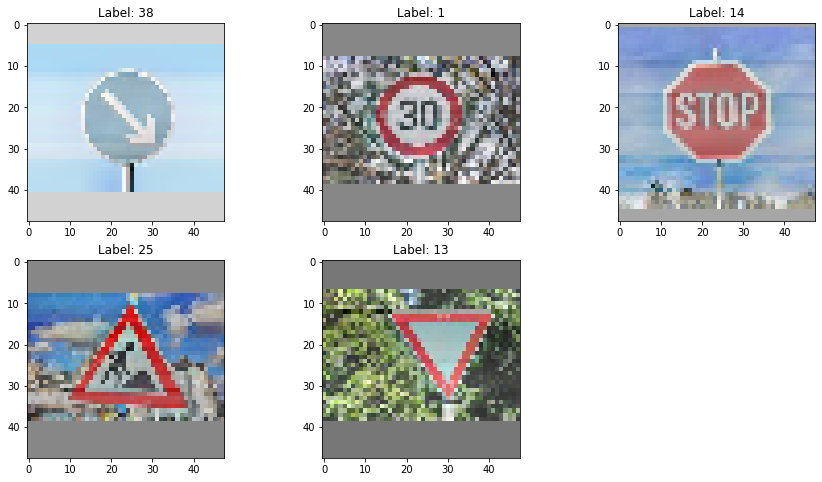

In [25]:
plt.figure(figsize = (15,8))
for idx, image in enumerate(test_signs_48):
    image = (image-image.min())/image.max()
    plt.subplot(2,3,idx+1)
    plt.imshow((image-image.min())/image.max())
    plt.title('Label: '+str(test_labels[idx]))

### Predict the Sign Type for Each Image

In [26]:
softmax = tf.nn.softmax(logits)
label = tf.argmax(logits,axis=1)
labels = None

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,'./CMSY8_v2')
    labels = sess.run(label,feed_dict={x: test_signs_48, dropout: 1.})
labels

array([38,  8, 35, 25, 13])

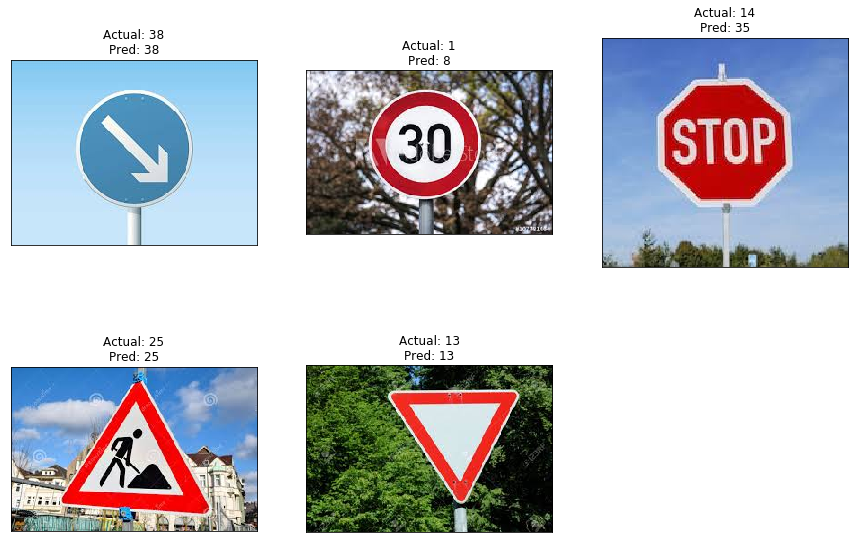

In [27]:
plt.figure(figsize = (15,10))
for idx, image in enumerate(test_signs):
    plt.subplot(2,3,idx+1)
    plt.imshow(image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual: ' + str(test_labels[idx]) + '\nPred: ' + str(labels[idx]))

### Analyze Performance

In [28]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./CMSY8_v2')
    performance = evaluate(test_signs_48,test_labels)
print("Performance = {:.2f}".format(performance))

Performance = 0.60


### Output Top 3 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [29]:
saver = tf.train.Saver()
tops = None
with tf.Session() as sess:
    saver.restore(sess,'./CMSY8_v2')
    tops = sess.run(tf.nn.top_k(softmax,k=5),feed_dict={x: test_signs_48, dropout: 1.})
    print(tops)

TopKV2(values=array([[1.00000000e+00, 1.00631475e-10, 5.16068351e-12, 6.43170359e-13,
        1.16818352e-13],
       [7.88566589e-01, 1.95210859e-01, 1.21551557e-02, 1.37008925e-03,
        1.28298590e-03],
       [9.99689341e-01, 1.82441130e-04, 1.01618381e-04, 1.13250398e-05,
        4.81237521e-06],
       [9.99853730e-01, 7.52278720e-05, 3.25366127e-05, 2.18662681e-05,
        7.78780031e-06],
       [1.00000000e+00, 1.78557116e-08, 1.61962497e-08, 8.65146621e-10,
        7.10229098e-10]], dtype=float32), indices=array([[38, 18,  5, 10, 13],
       [ 8,  5,  7,  4,  1],
       [35, 12, 14, 15, 37],
       [25, 11, 37, 28, 29],
       [13,  4,  1, 19, 18]], dtype=int32))


---

## Step 4 TODO: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [30]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")